# Mushashi and other RRMs

Here, we start from a couple of proteins from the 'RRM master alignment' to find out:
1. Where the secondary structure elements are
2. What the 'biophysical predictions' are
3. Relate these two to each other


## 1. Read in the information from the Multiple Sequence Alignment (MSA)

Here, we read in the information from the file containing the sequence data

In [72]:
# Here we get a pre-defined function
from utils import extractFastaInfo, extractClustalInfo

msaFilePath = "rrm_short_msa.fasta"

# Extract the information
(seqAlignInfo,seqIds) = extractFastaInfo(msaFilePath)

# Print the information
print(seqIds)

['PDB:6NTY:A:1', 'PDB:4ZKA:A:1', 'PDB:5LSL:D:1', 'PDB:1H6K:Z:2', 'PDB:2ADB:A:2', 'PDB:1FJ7:A:1']


## 2. Secondary structure information from the PDBe REST API

Via the [PDBe REST API](https://www.ebi.ac.uk/pdbe/api/doc/pdb.html) you can directly access information about PDB files. Here, we get information about secondary structures in the PDB files, but it is equally possible to get information on functional annotations, binding sites, ... .

Access to the API:

A) REST API

GET for individual queries and POST batch queries. [click here](https://www.ebi.ac.uk/pdbe/api/doc/pdb.html)

B) Python script

Below is an example for secondary structure information, other properties can be accessed in a similar way.

In [73]:
import requests
import json

def getSecondaryStructureData(pdbCodes):
    # API Post URL
    # Secondary structure info
    post_url = "https://www.ebi.ac.uk/pdbe/api/pdb/entry/secondary_structure/{}"
    
    responseDict = {}

    # Make POST request
    # WV 190206 - ADDED the 'data =' in below for it to work on Python dictionary
    for pdbCode in pdbCodes:
        response = requests.get(post_url.format(pdbCode))
        responseJson = json.loads(response.text)
        
        if responseJson:
            print("Data collected for '{}'".format(pdbCode))
            responseDict.update(responseJson)
        else:
            print("No data for '{}'".format(pdbCode))
    
    return responseDict


# The input should contain one or more comma-separated PDB ids, which we make here with
# some Python magic
pdbCodes = [seqId[4:8].lower() for seqId in seqIds]

# Get the secondary structure information, and print it
results1 = getSecondaryStructureData(pdbCodes)
print(results1)

# We are saving the data in a JSON file for later use, so we don't have to get the data again if we turn
# off the computer
json1 = json.dumps(results1)

secondaryStructureJsonFile = "SecondaryStructure.json"
f = open(secondaryStructureJsonFile, "w")
f.write(json1)
f.close()


Data collected for '6nty'
Data collected for '4zka'
Data collected for '5lsl'
Data collected for '1h6k'
Data collected for '2adb'
Data collected for '1fj7'
{'6nty': {'molecules': [{'entity_id': 1, 'chains': [{'chain_id': 'A', 'struct_asym_id': 'A', 'secondary_structure': {'helices': [{'start': {'author_residue_number': 33, 'author_insertion_code': None, 'residue_number': 16}, 'end': {'author_residue_number': 42, 'author_insertion_code': None, 'residue_number': 25}}, {'start': {'author_residue_number': 43, 'author_insertion_code': None, 'residue_number': 26}, 'end': {'author_residue_number': 45, 'author_insertion_code': None, 'residue_number': 28}}, {'start': {'author_residue_number': 72, 'author_insertion_code': None, 'residue_number': 55}, 'end': {'author_residue_number': 80, 'author_insertion_code': None, 'residue_number': 63}}], 'strands': [{'start': {'author_residue_number': 22, 'author_insertion_code': None, 'residue_number': 5}, 'sheet_id': 1, 'end': {'author_residue_number': 28,

### 3. Get the biophysical predictions

We here then get predictions of the protein behavior, from the https://www.bio2byte.be/b2btools/ server, where
you can interactively upload your sequence(s) and visualise them. Here, we send the MSA information
to the API.

In [8]:
import requests
import time

WAIT_TIME = 5
TOTAL_TIME = 3000

## input parameters ##
url = 'https://bio2byte.be/msatools/'
apiUrl = url + 'api/'

def getDataForMsa(inputFile,outputFile):

    # Read input MSA file
    file = open(inputFile, 'r')
    inputData = file.read()

    request_json = {"token": "J1H5G3F2D2",
                    "tool": 'msatoolsproteins',
                    'file_content': inputData}

    print(request_json)
    print("Posting data to server...")
    # Make POST request with Json Input body
    r = requests.post(url = apiUrl, data=request_json)
    get_address = json.loads(r.content.decode("utf-8"))["Location"]
    resultUrl = url + get_address

    print("Fetching results...")

    # Now get results - or fail when time limit reached
    time_waited = 0
    while time_waited / TOTAL_TIME < 1.0:

      # Get Request
      response = requests.get(resultUrl)

      if response.status_code == 202:
        print("  Waiting for results...")

      elif response.status_code == 200:
        queryResults = json.loads(response.text)
        break

      else:
        print("Server error, response {}.".format(response.status_code))
        break

      time.sleep(WAIT_TIME)
      time_waited += WAIT_TIME

    # save the results to a json file
    predJsonData = json.dumps(queryResults)
    f = open(outputFile, "w")
    f.write(predJsonData)
    f.close()

    return queryResults


# This is the file where the predictions are saved - can change the name if you re-run this
# for another set of protein!
predJsonFile = 'predictions.json'

results = getDataForMsa(msaFilePath,predJsonFile)

print(results)

{'token': 'J1H5G3F2D2', 'tool': 'msatoolsproteins', 'file_content': '>PDB:6NTY:A\n------------------------------------------------------------------------NAGKMFIGGL-----------SWQTSPDSLRDYFSKF-----------GEIRECMVMRDPTT---KRSRGFGFVTFA--DPASVDKVLGQPHHE------------LDSKTIDPKVAFPRR---------------------------------------------------------------------------------\n>PDB:4ZKA:A\n--------------------------------------------------------------------ENKSQPKRLHVSNI-----------PFRFRDPDLRQMFGQF-----------GKILDVEIIFNER-----GSKGFGFVTFE--NSADADRAREKLHGT-----------VVEGRKIEVNNATA-----------------------------------------------------------------------------------\n>PDB:5LSL:D\n-------------------------------------------------------------------------GNTVYVGNI-----------DPRITKEQLYELFIQI-----------NPVLRIKYPKDKVL---QAYQGYAFIEFY--NQGDAQYAIKIMNNTV----------RLYDRLIKVR--QV-----------------------------------------------------------------------------------\n>PDB:1H6K:Z\n---------------------------------------------------

### 4. Integrate and visualise
We can then also visualise the results.

Note that we have multiple results, you can change the currentProteinIndex in code below
to get the results for other proteins (don't forget to go to 'Cell' and click 'Run Cells'
to re-run this particular code block!).

Showing data for 6nty chain A


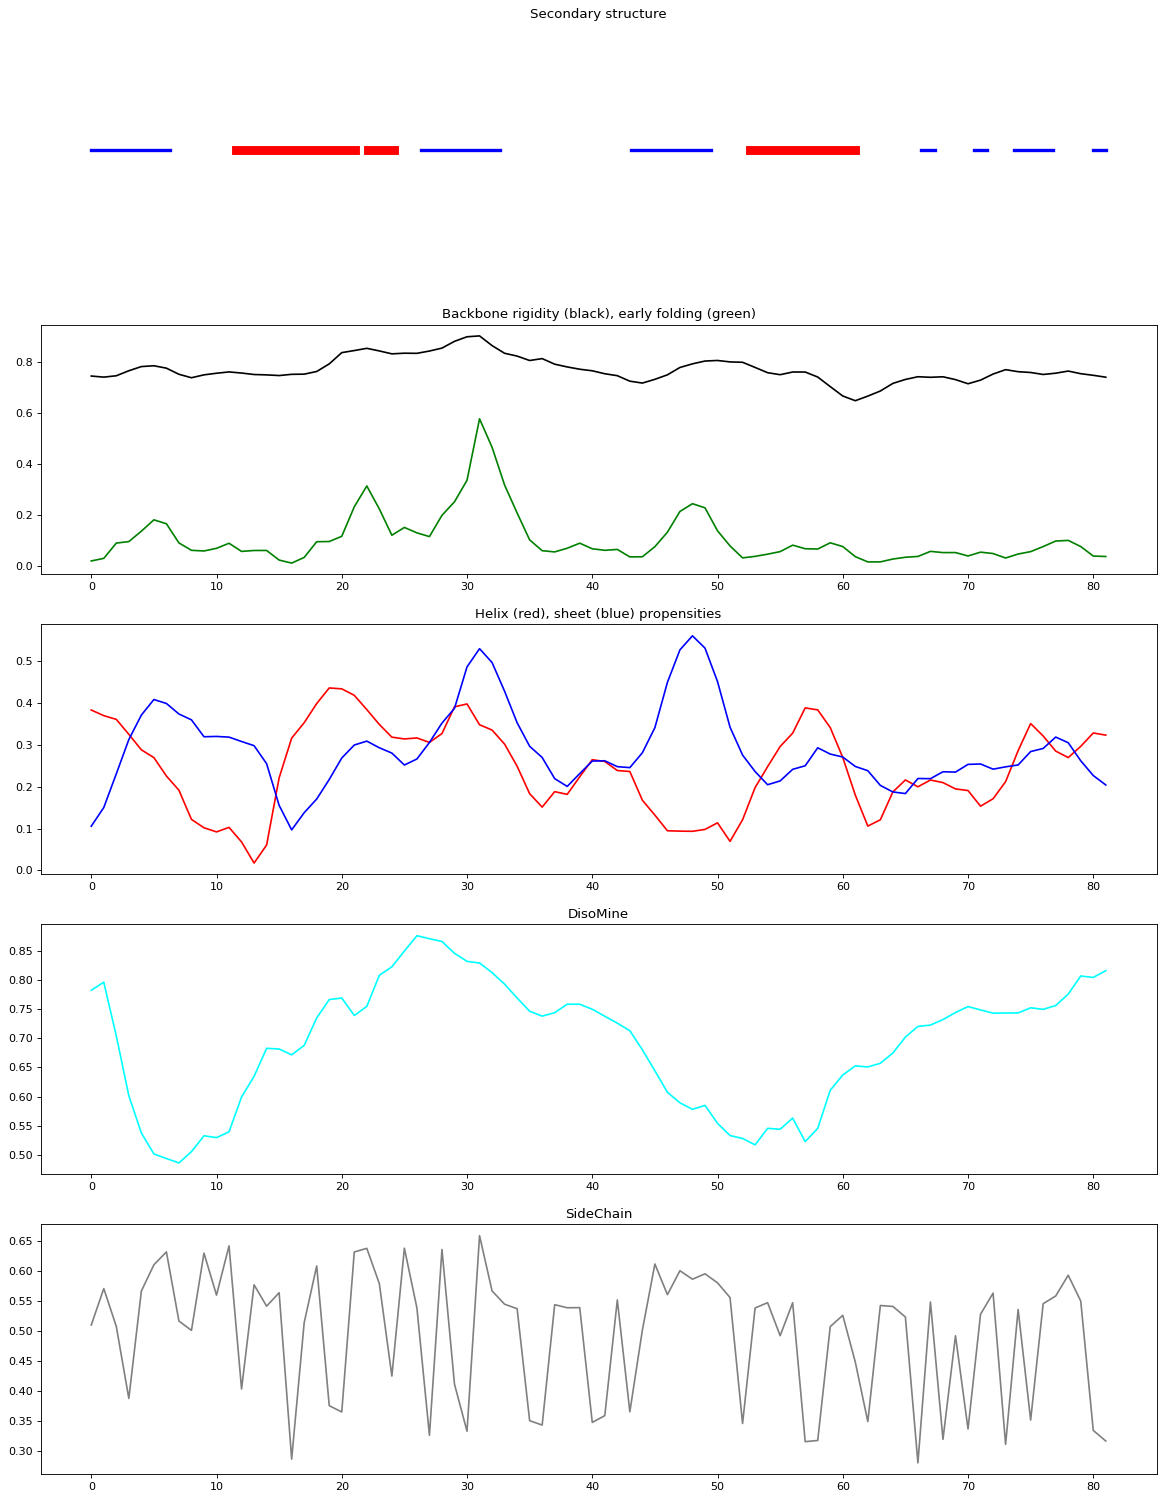

In [71]:
import matplotlib.pyplot as plt
import json

# Read Json file with secondary structures
file = open(secondaryStructureJsonFile, 'r')
ss_json = json.loads(file.read())

# Read Json file with predictions
file = open(predJsonFile, 'r')
request_json = json.loads(file.read())

# Note that here we are showing the results for the first protein
# Index 5 in the results list is Mushashi
currentProteinIndex = 5
currentProteinId = request_json["results"][currentProteinIndex]['proteinID']
currentPDBCode = currentProteinId[4:8].lower()
currentPDBChain = currentProteinId[9:10]

print("Showing data for {} chain {}".format(currentPDBCode,currentPDBChain))

# residue index
seq = request_json["results"][currentProteinIndex]['sequence']
#Secondary structure
helices = []
sheets = []
currentInfo = ss_json[currentPDBCode]
for moleculeInfo in currentInfo['molecules']:
    for chainInfo in moleculeInfo['chains']:
        if chainInfo['chain_id'] == currentPDBChain:
            secStrucInfo = chainInfo['secondary_structure']
            
            for helixInfo in secStrucInfo['helices']:
                helices.append((helixInfo['start']['residue_number'],helixInfo['end']['residue_number']))
            for strandInfo in secStrucInfo['strands']:
                sheets.append((strandInfo['start']['residue_number'],strandInfo['end']['residue_number']))

                
#DisoMine Score
disomine = [value for value in request_json["results"][currentProteinIndex]['disoMine'] if value != None]
#backbone Score
backbone = [value for value in request_json["results"][currentProteinIndex]['backbone'] if value != None]
#sidechain Score
sidechain = [value for value in request_json["results"][currentProteinIndex]['sidechain'] if value != None]
#efoldmine Score
efoldmine = [value for value in request_json["results"][currentProteinIndex]['earlyFolding'] if value != None]
#helix propensity Score
helix = [value for value in request_json["results"][currentProteinIndex]['helix'] if value != None]
#sheet propensity Score
sheet = [value for value in request_json["results"][currentProteinIndex]['sheet'] if value != None]

# creating a plot
fig = plt.figure(figsize=(18, 24), dpi= 80, facecolor='w', edgecolor='k')

# Plotting the secondary structure
axes = fig.add_subplot(511)
axes.set_ylim(0.01,-0.01)
for (start,end) in helices:
    axes.plot([start,end], [0,0], color="red", linewidth=8)
for (start,end) in sheets:
    axes.plot([start,end], [0,0], color="blue", linewidth = 3)
axes.set_title("Secondary structure")
axes.axis('off')

#Plotting the Backbone results
axes = fig.add_subplot(512)
axes.plot(range(len(seq)), backbone, color="black")
axes.plot(range(len(seq)), efoldmine, color="g")
axes.set_title("Backbone rigidity (black), early folding (green)")

#Plotting the helix and sheet propensity results
axes = fig.add_subplot(513)
axes.plot(range(len(seq)), helix, color="r")
axes.plot(range(len(seq)), sheet, color="b")

axes.set_title("Helix (red), sheet (blue) propensities")

#Plotting the DisoMine results
axes = fig.add_subplot(514)
axes.plot(range(len(seq)), disomine, color="cyan")
axes.set_title("DisoMine")

#Plotting the SideChain results
axes = fig.add_subplot(515)
axes.plot(range(len(seq)), sidechain, color="grey")
axes.set_title("SideChain")

plt.show()



